<a href="https://colab.research.google.com/github/codingCapricorn/MCMC-Algorithm-Implementation/blob/master/MCMC_ALGORITHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Markov Chain Monte Carlo (MCMC) Algorithm

In [0]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
%precision 4
plt.style.use('ggplot')

from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial

np.random.seed(1234)

Bayesian Data Analysis :::::::>>>>>>

The fundamental objective of Bayesian data analysis is to determine the posterior distribution

p(θ | X)=p(X | θ)p(θ)p(X)

where the denominator is

p(X)=∫dθ∗p(X | θ∗)p(θ∗)

Here,

p(X | θ) is the likelihood,

p(θ) is the prior and

p(X) is a normalizing constant also known as the evidence or marginal likelihood


-->>We will use the toy example of estimating the bias of a coin given a sample consisting of n tosses to illustrate a few of the approaches.

-->>Analytical solution

If we use a beta distribution as the prior, then the posterior distribution has a closed form solution. 
This is shown in the example below. Some general points:

We need to choose a prior distribtuiton family (i.e. the beta here) as well as its parameters (here a=10, b=10)
The prior distribution may be relatively uninformative (i.e. more flat) or inforamtive (i.e. more peaked)
The posterior depends on both the prior and the data
As the amount of data becomes large, the posterior approximates the MLE
An informative prior takes more data to shift than an uninformative one Of course, it is also important the model used (i.e. the likelihood) is appropriate for the fitting the data.
The mode of the posterior distribution is known as the maximum a posteriori (MAP) estimate (cf MLE which is the mode of the likelihood)

In Bayesian statistics, we want to estiamte the posterior distribution, but this is often intractable due to the high-dimensional integral in the denominator (marginal likelihood).

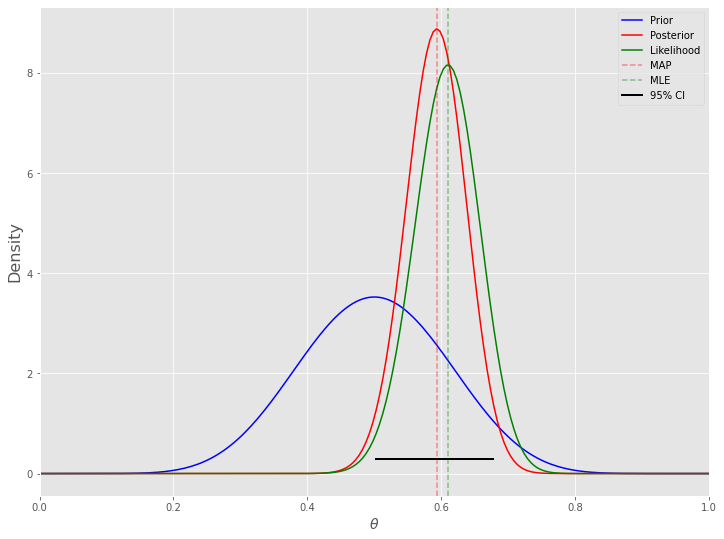

In [2]:
n = 100
h = 61
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

a, b = 10, 10
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();


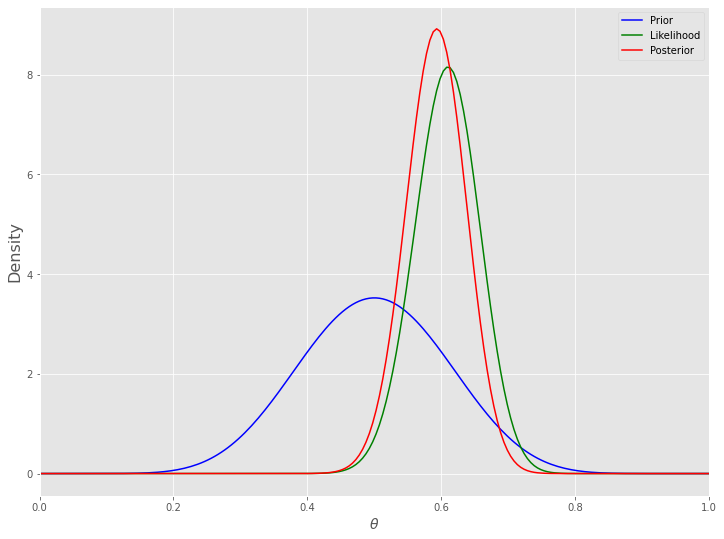

In [4]:
'''
Numerical integration
'''

thetas = np.linspace(0, 1, 200)
prior = st.beta(a, b)

post = prior.pdf(thetas) * st.binom(n, thetas).pmf(h)
post /= (post.sum() / len(thetas))

plt.figure(figsize=(12, 9))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

#Markov Chain Monte Carlo Algorithms :::::::>>>>>>

MCMC methods are used to approximate the posterior distribution of a parameter of interest by random sampling in a probabilistic space.

With MCMC,i.e.Markov Chain + Monte Carlo Algorithms, 
we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). 

Under certain condiitons, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - 

instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution of interest. 

The nice thing is that this target distribution only needs to be proportional to the posterior distribution, which means we don’t need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. 

MCMC and it's 3 common veriants - 

        (1)Metropolis-Hastings Sampler Algorithm
        (2)Gibbs Sampler Algorithm 
        (3)slice sampling Sampler Algorithm

#1.Metropolis-Hastings sampler --->>>

To carry out the Metropolis-Hastings algorithm, we need to draw random samples from the folllowing distributions

the standard uniform distribution
a proposal distriution p(x) that we choose to be N(0,σ)
the target distribution g(x) which is proportional to the posterior probability

Given an initial guess for θ with positive probability of being drawn, the Metropolis-Hastings algorithm proceeds as follows

Choose a new proposed value (θp) such that θp=θ+Δθ where Δθ∼N(0,σ)

Caluculate the ratio

ρ=g(θp | X)g(θ | X)

where g is the posterior probability.

If the proposal distribution is not symmetrical, we need to weight the accceptanc probablity to maintain detailed balance (reversibilty) of the stationary distribution, and insetad calculate

ρ=g(θp | X)p(θ | θp)g(θ | X)p(θp | θ)

Since we are taking ratios, the denominator cancels any distribution proporational to g will also work - so we can use

ρ=p(X|θp)p(θp)p(X|θ)p(θ)
If ρ≥1, then set θ=θp

If ρ<1, then set θ=θp with probability ρ, otherwise set θ=θ (this is where we use the standard uniform distribution)

Repeat the earlier steps.

In [5]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 100
h = 61
a = 10
b = 10
lik = st.binom
prior = st.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 10000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print ("Efficiency = ", naccept/niters)

Efficiency =  0.19


AttributeError: ignored

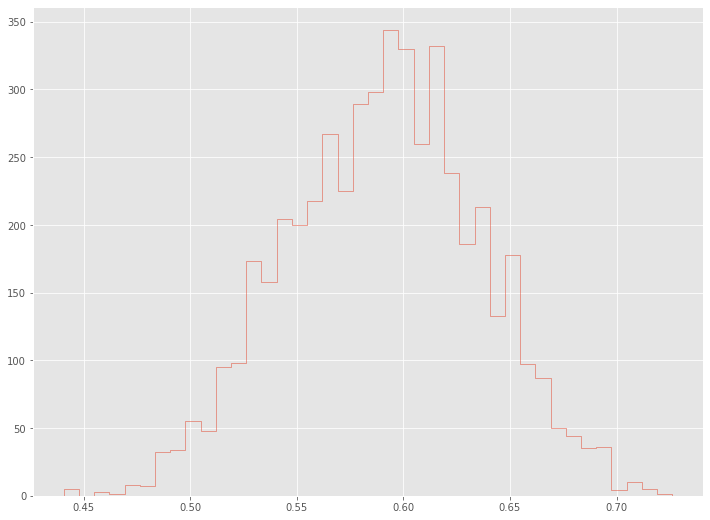

In [6]:
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

In [0]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [0]:
n = 100
h = 61
lik = st.binom
prior = st.beta(a, b)
sigma = 0.05
niters = 100

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]

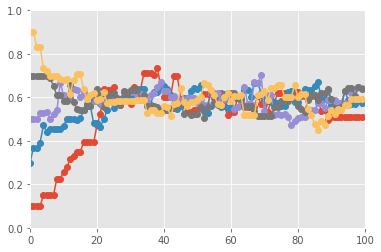

In [9]:
# Convergence of multiple chains

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

#2.GIBBS SAMPLER ---->>>

Suppose we have a vector of parameters θ=(θ1,θ2,…,θk), and we want to estimate the joint posterior distribution p(θ|X).
Suppose we can find and draw random samples from all the conditional distributions

p(θ1|θ2,…θk,X)p(θ2|θ1,…θk,X)…p(θk|θ1,θ2,…,X)

With Gibbs sampling, the Markov chain is constructed by sampling from the conditional distribution for each parameter θi in turn, treating all other parameters as observed.

When we have finished iterating over all parameters, we are said to have completed one cycle of the Gibbs sampler. Where it is difficult to sample from a conditional distribution, 
we can sample using a Metropolis-Hastings algorithm instead - this is known as Metropolis wihtin Gibbs.

In [0]:
#Setup
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes."""
    return np.clip(theta**z * (1-theta)**(N-z), 0, 1)

In [0]:
def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [0]:
def make_thetas(xmin, xmax, n):
    xs = np.linspace(xmin, xmax, n)
    widths =(xs[1:] - xs[:-1])/2.0
    thetas = xs[:-1]+ widths
    return thetas

In [0]:
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection), figsize=(12,3))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior)
        ax[1].contour(X, Y, likelihood)
        ax[2].contour(X, Y, posterior)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()

In [0]:
thetas1 = make_thetas(0, 1, 101)
thetas2 = make_thetas(0, 1, 101)
X, Y = np.meshgrid(thetas1, thetas2)

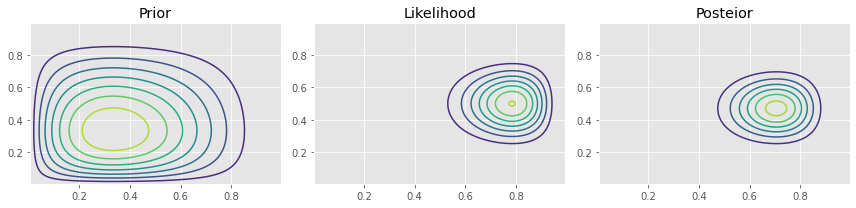

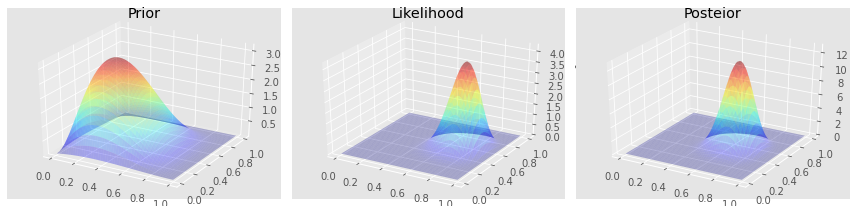

In [15]:
#Analytical Solution For GIBBS SAMPLER
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = stats.beta(a, b).pdf(X) * stats.beta(a, b).pdf(Y)
likelihood = bern2(X, Y, z1, z2, N1, N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)
make_plots(X, Y, prior, likelihood, posterior)
make_plots(X, Y, prior, likelihood, posterior, projection='3d')

In [0]:
#Grid approximation
def c2d(thetas1, thetas2, pdf):
    width1 = thetas1[1] - thetas1[0]
    width2 = thetas2[1] - thetas2[0]
    area = width1 * width2
    pmf = pdf * area
    pmf /= pmf.sum()
    return pmf

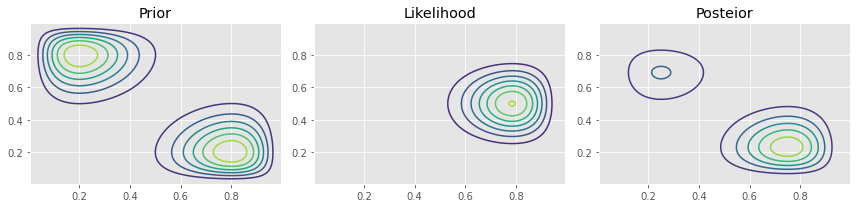

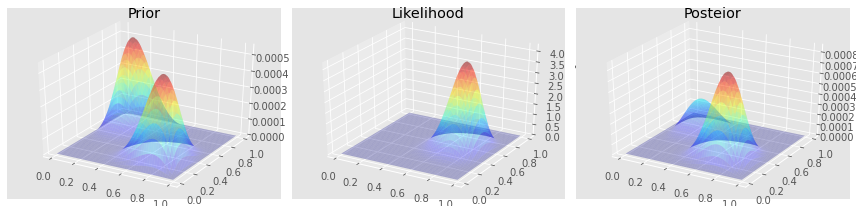

In [17]:
_prior = bern2(X, Y, 2, 8, 10, 10) + bern2(X, Y, 8, 2, 10, 10)
prior_grid = c2d(thetas1, thetas2, _prior)
_likelihood = bern2(X, Y, 1, 1, 2, 3)
posterior_grid = _likelihood * prior_grid
posterior_grid /= posterior_grid.sum()
make_plots(X, Y, prior_grid, likelihood, posterior_grid)
make_plots(X, Y, prior_grid, likelihood, posterior_grid, projection='3d')

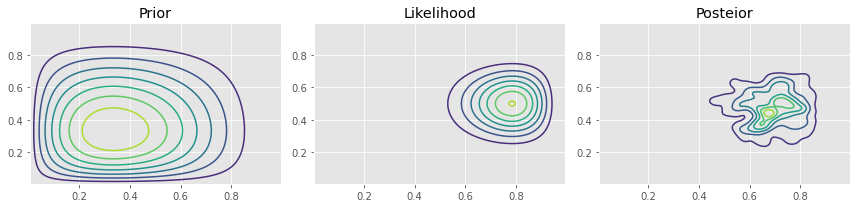

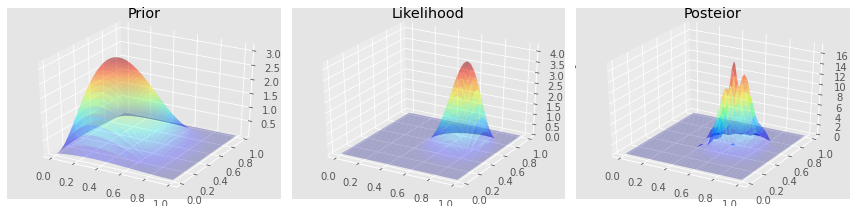

In [18]:
#Metropolis
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin, 2), np.float)
for i in range(niters):
    new_theta = stats.multivariate_normal(theta, sigma).rvs()
    p = min(target(*new_theta)/target(*theta), 1)
    if np.random.rand() < p:
        theta = new_theta
    if i >= burnin:
        thetas[i-burnin] = theta
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_metroplis, projection='3d')

In [0]:
#Gibbs
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
lik = partial(bern2, z1=z1, z2=z2, N1=N1, N2=N2)
target = lambda theta1, theta2: prior(theta1, theta2) * lik(theta1, theta2)

theta = np.array([0.5, 0.5])
niters = 10000
burnin = 500
sigma = np.diag([0.2,0.2])

thetas = np.zeros((niters-burnin,2), np.float)
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]

    if i >= burnin:
        thetas[i-burnin] = theta

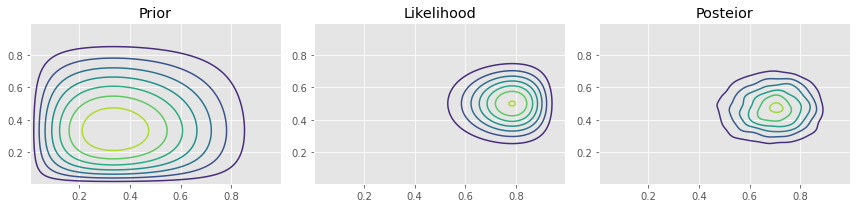

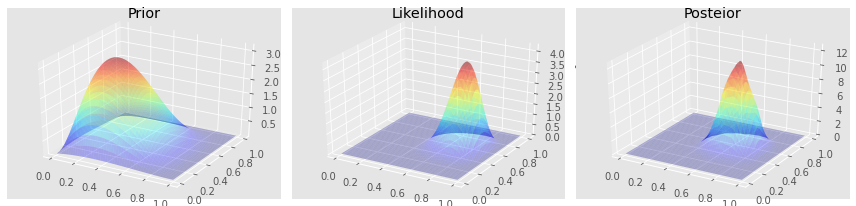

In [20]:
kde = stats.gaussian_kde(thetas.T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs)
make_plots(X, Y, prior(X, Y), lik(X, Y), posterior_gibbs, projection='3d')

#3.SLICE SAMPLER --->>>

Yet another MCMC algorithm is slice sampling.
In slice sampling, the Markov chain is constructed by using an auxiliary variable representing slices throuth the (unnomrmalized) posterior distribution that is constructed using only the current parmater value.

Like Gibbs sampling, there is no tuning processs and all proposals are accepted. 
For slice sampling, you either need the inverse distibution function or some way to estimate it.

A toy example illustrates the process - 
Suppose we want to draw random samples from the posterior distribution N(0,1) using slice sampling

Start with some value x - sample y from U(0,f(x)) -this is the horizontal “slice” that gives the method its name - sample the next x from f−1(y) - 
this is typicaly done numerically - repeat

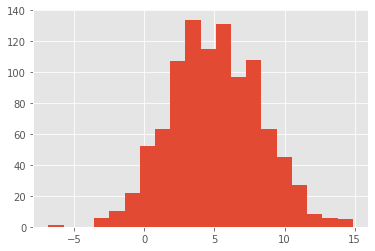

In [21]:
# Code illustrating idea of slice sampler

import scipy.stats as stats

dist = stats.norm(5, 3)
w = 0.5
x = dist.rvs()

niters = 1000
xs = []
while len(xs) < niters:
    y = np.random.uniform(0, dist.pdf(x))
    lb = x
    rb = x
    while y < dist.pdf(lb):
        lb -= w
    while y < dist.pdf(rb):
        rb += w
    x = np.random.uniform(lb, rb)
    if y > dist.pdf(x):
        if np.abs(x-lb) < np.abs(x-rb):
            lb = x
        else:
            lb = y
    else:
        xs.append(x)
plt.hist(xs, 20);

Hierarchical models ::::::

Hierarchical models have the following structure - 
first we specify that the data come from a distribution with parameers θ

X∼f(X | θ)

and that the parameters themselves come from anohter distribution with hyperparameters λ

θ∼g(θ | λ)

and finally that λ comes from a prior distribution

λ∼h(λ)

More levels of hiearchy are possible - i.e you can specify hyper-hyperparameters for the dsitribution of λ and so on.

We now specify the hiearchcical model - 
note change of notation from the overview above - 
that θ is λ (parameter) and λ is β (hyperparameter) simply because λ is traditional for the Poisson distribution parameter.

The likelihood f is

∏i=110Poisson(λiti)

We let the prior g for λ be

Gamma(α,β)

with α=1.8 (an improper prior whose integral does not sum to 1)

and let the hyperprior h for β to be

Gamma(γ,δ)
with γ=0.01 and δ=1.

There are 11 unknown parameters (10 λs and β) in this hierarchical model.

The posterior is

p(λ,β | y,t)=∏i=110Poisson(λiti)×Gamma(α,β)×Gamma(γ,δ)

with the condiitonal distributions needed for Gibbs sampling given by

p(λi | λ−i,β,y,t)=Gamma(yi+α,ti+β)
and

p(β | λ,y,t)=Gamma(10α+γ,δ+∑i=110λi)


In [22]:
from numpy.random import gamma as rgamma # rename so we can use gamma for parameter name
def lambda_update(alpha, beta, y, t):
    return rgamma(size=len(y), shape=y+alpha, scale=1.0/(t+beta))

def beta_update(alpha, gamma, delta, lambd, y):
    return rgamma(size=1, shape=len(y) * alpha + gamma, scale=1.0/(delta + lambd.sum()))

def gibbs(niter, y, t, alpha, gamma, delta):
    lambdas_ = np.zeros((niter, len(y)), np.float)
    betas_ = np.zeros(niter, np.float)

    lambda_ = y/t

    for i in range(niter):
        beta_ = beta_update(alpha, gamma, delta, lambda_, y)
        lambda_ = lambda_update(alpha, beta_, y, t)

        betas_[i] = beta_
        lambdas_[i,:] = lambda_

    return betas_, lambdas_
alpha = 1.8
gamma = 0.01
delta = 1.0
beta0 = 1
y = np.array([5, 1, 5, 14, 3, 19, 1, 1, 4, 22], np.int)
t = np.array([94.32, 15.72, 62.88, 125.76, 5.24, 31.44, 1.05, 1.05, 2.10, 10.48], np.float)
niter = 1000
betas, lambdas = gibbs(niter, y, t, alpha, gamma, delta)
print ('%.3f' % betas.mean())
print ('%.3f' % betas.std(ddof=1))
print (lambdas.mean(axis=0))
print (lambdas.std(ddof=1, axis=0))

2.446
0.700
[0.069  0.1558 0.1037 0.1247 0.6308 0.6062 0.8361 0.8065 1.3185 1.8456]
[0.0264 0.0949 0.0401 0.0317 0.2873 0.1378 0.5073 0.4833 0.6175 0.3847]


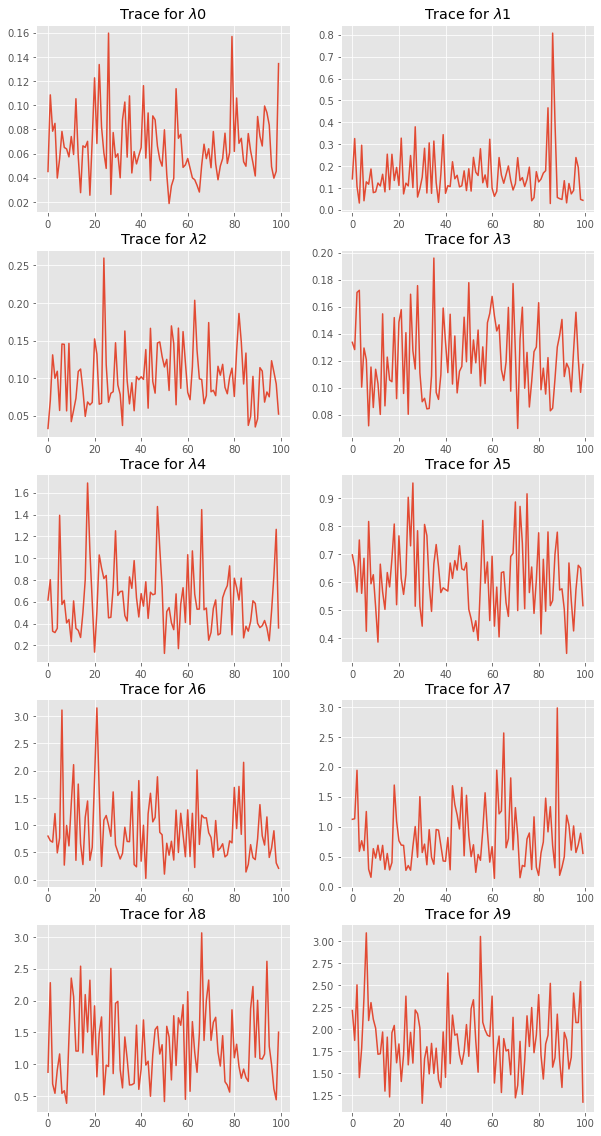

In [23]:
plt.figure(figsize=(10, 20))
for i in range(len(lambdas.T)):
    plt.subplot(5,2,i+1)
    plt.plot(lambdas[::10, i]);
    plt.title('Trace for $\lambda$%d' % i)